Обучение агента: 100%|██████████| 5000/5000 [39:47<00:00,  2.09it/s]   


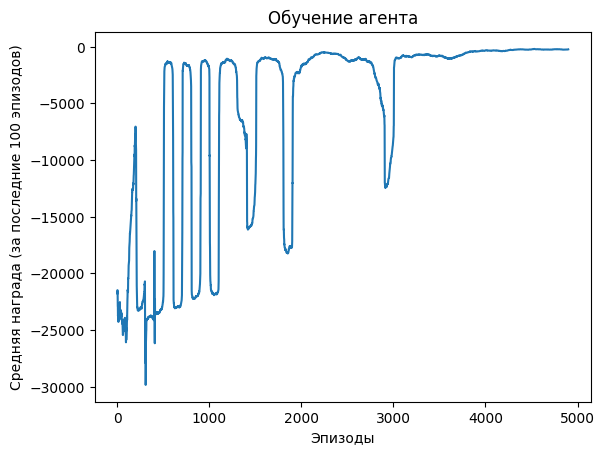

In [4]:
# Импорт необходимых библиотек после перезапуска
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# Гиперпараметры
NUM_EPISODES = 5000
ALPHA = 0.1       # Скорость обучения
GAMMA = 0.9       # Дисконтирующий фактор
EPSILON = 0.1     # Вероятность случайного действия
NUM_VESSELS = 5   # Количество сосудов
TOTAL_VOLUME = 25 # Общий объём жидкости
TARGET_VOLUME = TOTAL_VOLUME // NUM_VESSELS  # Целевой объём в каждом сосуде

# Среда
class LiquidEnv:
    def __init__(self, num_vessels=NUM_VESSELS, total_volume=TOTAL_VOLUME):
        self.num_vessels = num_vessels
        self.total_volume = total_volume
        self.target_volume = total_volume // num_vessels
        self.state = None

    def reset(self):
        # Случайное начальное состояние
        while True:
            state = np.random.randint(0, self.total_volume + 1, size=self.num_vessels)
            if sum(state) == self.total_volume:
                self.state = tuple(state)
                return self.state

    def step(self, action):
        # Переливаем v литров из сосуда i в сосуд j
        i, j, v = action
        if self.state[i] >= v:
            new_state = list(self.state)
            new_state[i] -= v
            new_state[j] += v
            self.state = tuple(new_state)
        
        # Вознаграждение и проверка завершения
        reward = -1  # Штраф за действие
        done = all(volume == self.target_volume for volume in self.state)
        return self.state, reward, done

    def available_actions(self):
        # Генерация всех возможных действий
        actions = []
        for i in range(self.num_vessels):
            for j in range(self.num_vessels):
                if i != j:
                    for v in range(1, self.state[i] + 1):
                        actions.append((i, j, v))
        return actions
    
q_table = defaultdict(float)
# Q-обучение
def q_learning(env, num_episodes):
    rewards = []

    for episode in tqdm(range(num_episodes), desc="Обучение агента"):
        state = env.reset()
        total_reward = 0

        while True:
            actions = env.available_actions()

            # Epsilon-greedy выбор действия
            if np.random.rand() < EPSILON:
                action = actions[np.random.choice(len(actions))]
            else:
                q_values = [q_table[(state, a)] for a in actions]
                action = actions[np.argmax(q_values)]

            # Выполнение действия
            next_state, reward, done = env.step(action)
            total_reward += reward

            # Обновление Q-таблицы
            max_next_q = max([q_table[(next_state, a)] for a in env.available_actions()], default=0)
            q_table[(state, action)] += ALPHA * (reward + GAMMA * max_next_q - q_table[(state, action)])

            state = next_state
            if done:
                break
        rewards.append(total_reward)
    return rewards

# Обучение
env = LiquidEnv()
rewards = q_learning(env, NUM_EPISODES)

# График средней награды
window = 100
avg_rewards = [np.mean(rewards[i:i+window]) for i in range(len(rewards) - window)]

plt.plot(avg_rewards)
plt.xlabel('Эпизоды')
plt.ylabel('Средняя награда (за последние 100 эпизодов)')
plt.title('Обучение агента')
plt.show()

In [15]:
def test_agent(env, q_table, initial_state):
    state = initial_state
    env.state = state  # Устанавливаем начальное состояние
    steps = 0
    total_reward = 0
    done = False
    
    print(f"Начальное состояние: {state}")
    
    while not done:
        # Выбор лучшего действия на основе Q-таблицы
        actions = env.available_actions()
        q_values = [q_table.get((state, a), 0) for a in actions]
        best_action = actions[np.argmax(q_values)]
        
        # Выполнение действия
        state, reward, done = env.step(best_action)
        total_reward += reward
        steps += 1
        
    
    print(f"Конечное состояние: {state}")
    print(f"Количество шагов: {steps}, Итоговая награда: {total_reward}")
    return steps, total_reward

# Пример начального состояния
initial_state = (3, 5, 7, 8, 2)  # Задайте произвольное начальное состояние

# Тестируем агента
test_agent(env, q_table, initial_state)

Начальное состояние: (3, 5, 7, 8, 2)
Конечное состояние: (5, 5, 5, 5, 5)
Количество шагов: 5, Итоговая награда: -5


(5, -5)